In [ ]:
# 0. 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import pickle

In [21]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else 'cpu')
print(f'다음 기기로 학습 : {device}')

다음 기기로 학습 : cuda


In [22]:
# 1. 데이터 불러오기 및 기본 전처리
df = pd.read_csv("./Data/Dummy02_ver01 copy.csv")

# event_time 컬럼을 datetime 형식으로 변환
df['event_time'] = pd.to_datetime(df['event_time'])

# epc_code, product_serial, event_time 순으로 정렬 (각 제품별 이벤트 순서를 보장)
df = df.sort_values(by=['epc_code', 'product_serial', 'event_time'])
print("데이터 샘플:")
display(df.head(10))

데이터 샘플:


,epc_code,product_serial,product_name,hub_type,event_type,event_time,latitude,longitude
0,001.8805843.584374.000000001,1,Product 1,Yeongju,commissioning,2025-01-21 17:54:00,36.825088,128.634847
1,001.8805843.584374.000000001,1,Product 1,Yeongju,aggregation,2025-01-21 18:15:00,36.825088,128.634847
2,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_inbound,2025-01-21 18:55:00,36.825088,128.634847
3,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_outbound,2025-01-25 07:35:00,36.825088,128.634847
4,001.8805843.584374.000000001,1,Product 1,Busan_yangsan,stock_inbound(HUB),2025-01-25 10:51:00,35.354865,129.043881
5,001.8805843.584374.000000001,1,Product 1,Busan_yangsan,stock_outbound(HUB),2025-03-02 04:15:00,35.354865,129.043881
6,001.8805843.584374.000000001,1,Product 1,Busan_dongnea,stock_inbound(Wholesaler),2025-03-02 12:21:00,35.202279,129.083947
7,001.8805843.584374.000000001,1,Product 1,Busan_dongnea,stock_outbound(Wholesaler),2025-03-28 03:16:00,35.202279,129.083947
8,001.8805843.584374.000000001,1,Product 1,Busan_gumjung,stock_inbound(Reseller),2025-03-28 07:33:00,35.259242,129.092119
9,001.8805843.584374.000000001,1,Product 1,Busan_gumjung,stock_outbound(Sell),2025-04-17 14:25:00,35.259242,129.092119


In [23]:
# 2. 시간 정보 처리: 각 제품별 첫 이벤트를 기준으로한 시간 차이(time_delta) 생성
# (각 이벤트가 첫 이벤트 이후 몇 초 후에 발생했는지를 수치화)
df['time_delta'] = df.groupby(['epc_code', 'product_serial'])['event_time'] \
                      .transform(lambda x: (x - x.min()).dt.total_seconds())

In [ ]:
# 3. 변수 인코딩: event_type과 hub_type
# 이벤트 종류(event_type) & 허브 타입(hub_type) 인코딩
encoder = LabelEncoder()
df[['event_type_enc', 'hub_type_enc']] = encoder.fit_transform(df[['event_type', 'hub_type']])

# 위도, 경도 정규화
scaler = MinMaxScaler()
df[['latitude_scaled', 'longitude_scaled']] = scaler.fit_transform(df[['latitude', 'longitude']])

# 이전 위치 정보 추가
df['prev_latitude'] = df.groupby(['epc_code', 'product_serial'])['latitude'].shift(1)
df['prev_longitude'] = df.groupby(['epc_code', 'product_serial'])['longitude'].shift(1)

# 벡터화된 거리 계산 함수
def compute_distance(lat1, lon1, lat2, lon2):
    if np.isnan(lat2) or np.isnan(lon2):  # 첫 번째 row는 NaN이므로 0으로 설정
        return 0
    return geodesic((lat1, lon1), (lat2, lon2)).km

vectorized_distance = np.vectorize(compute_distance)
df['distance_km'] = vectorized_distance(df['latitude'], df['longitude'], df['prev_latitude'], df['prev_longitude'])

# 시간 차이(time_delta) 및 이동 거리(distance_km) 정규화
df['time_delta_scaled'] = scaler.fit_transform(df[['time_delta']])
df['distance_km_scaled'] = scaler.fit_transform(df[['distance_km']])

# 확인
print("전처리 후 데이터 샘플:")
display(df[['epc_code', 'product_serial', 'event_time', 'time_delta', 
          'event_type', 'event_type_enc', 'hub_type', 'hub_type_enc', 
          'time_delta_scaled', 'latitude_scaled', 'longitude_scaled', 'distance_km', 'distance_km_scaled']].head(10))

전처리 후 데이터 샘플:


,epc_code,product_serial,event_time,time_delta,event_type,event_type_enc,hub_type,hub_type_enc,time_delta_scaled,latitude_scaled,longitude_scaled,distance_km,distance_km_scaled
0,001.8805843.584374.000000001,1,2025-01-21 17:54:00,0.0,commissioning,3.0,Yeongju,15.0,0.000000,0.688215,0.799475,0,0.000000
1,001.8805843.584374.000000001,1,2025-01-21 18:15:00,1260.0,aggregation,2.0,Yeongju,15.0,0.000105,0.688215,0.799475,0,0.000000
2,001.8805843.584374.000000001,1,2025-01-21 18:55:00,3660.0,WMS_inbound,0.0,Yeongju,15.0,0.000304,0.688215,0.799475,0,0.000000
3,001.8805843.584374.000000001,1,2025-01-25 07:35:00,308460.0,WMS_outbound,1.0,Yeongju,15.0,0.025655,0.688215,0.799475,0,0.000000
4,001.8805843.584374.000000001,1,2025-01-25 10:51:00,320220.0,stock_inbound(HUB),4.0,Busan_yangsan,2.0,0.026633,0.094767,0.978846,167,0.690083
5,001.8805843.584374.000000001,1,2025-03-02 04:15:00,3406860.0,stock_outbound(HUB),7.0,Busan_yangsan,2.0,0.283357,0.094767,0.978846,0,0.000000
6,001.8805843.584374.000000001,1,2025-03-02 12:21:00,3436020.0,stock_inbound(Wholesaler),6.0,Busan_dongnea,0.0,0.285782,0.033176,0.996416,17,0.070248
7,001.8805843.584374.000000001,1,2025-03-28 03:16:00,5649720.0,stock_outbound(Wholesaler),9.0,Busan_dongnea,0.0,0.469901,0.033176,0.996416,0,0.000000
8,001.8805843.584374.000000001,1,2025-03-28 07:33:00,5665140.0,stock_inbound(Reseller),5.0,Busan_gumjung,1.0,0.471183,0.056169,1.000000,6,0.024793
9,001.8805843.584374.000000001,1,2025-04-17 14:25:00,7417860.0,stock_outbound(Sell),8.0,Busan_gumjung,1.0,0.616961,0.056169,1.000000,0,0.000000


In [25]:
# 4. 시퀀스 데이터 구성
# 각 제품(또는 epc_code, product_serial 단위)의 이벤트 시퀀스를 구성합니다.
feature_columns = ['event_type_enc', 'hub_type_enc', 'time_delta_scaled', 'distance_km_scaled']

def create_sequence(group, feature_columns):
    return group[feature_columns].to_numpy(dtype=np.float32)

# 각 제품별 그룹으로 시퀀스 구성
grouped = df.groupby(['epc_code', 'product_serial'])
sequences = [create_sequence(x, feature_columns).tolist() for _, x in grouped]

# 최대 시퀀스 길이 계산 (모든 시퀀스 중 가장 긴 길이를 찾음)
max_seq_length = max(len(seq) for seq in sequences)
print("최대 시퀀스 길이:", max_seq_length)

# 시퀀스 패딩 적용: pad_sequences를 사용하여 길이가 max_seq_length로 고정되도록 패딩합니다.
X = pad_sequences(sequences, padding='post', dtype='float32', maxlen = max_seq_length, value = -1.0)
print("패딩된 시퀀스 데이터 shape:", X.shape)
# 예시 출력: (제품 수, max_seq_length, feature 개수)

최대 시퀀스 길이: 10
패딩된 시퀀스 데이터 shape: (11103, 10, 4)


In [26]:
# 5. LSTM Autoencoder 모델 구성
# 입력 데이터 shape: (timesteps, input_dim)
input_dim = X.shape[2]    # feature 수
timesteps = X.shape[1]    # 시퀀스 길이
latent_dim = 64           # 잠재 공간 차원 (조정 가능)

# 모델 구성
inputs = Input(shape=(timesteps, input_dim))
masked = Masking(mask_value = -1.0)(inputs)

# 인코더: LSTM을 사용하여 시퀀스를 잠재 벡터로 인코딩
encoded = LSTM(latent_dim, activation='tanh')(masked)

# 디코더: RepeatVector와 LSTM을 사용하여 시퀀스를 재구성
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

# Autoencoder 모델 정의 및 컴파일
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='Adam', loss='mse') # Adam -> RMSprop 변경, mse -> mae 변경
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 10, 4)     │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 10, 4)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 10)        │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     17,664 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 10, 64)    │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 10, 4)     │      1,104 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 4)     │         20 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,788 (73.39 KB)

 Trainable params: 18,788 (73.39 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 6. 커스텀 콜백: 매 에포크마다 현재 모델로 예측한 재구성 오차를 기준으로
#    (재구성 오차의 평균 + 3×표준편차)를 임계치로 하여, 초과하는 샘플의 개수를 계산
class AnomalyCountCallback(Callback):
    def __init__(self, training_data):
        super().__init__()
        self.training_data = training_data
        self.epoch_anomaly_counts = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_pred = self.model.predict(self.training_data, verbose=0)
        
        # 각 샘플별 재구성 오차
        reconstruction_errors = np.mean(np.square(X_pred - self.training_data), axis=(1,2))
        
        # 현재 에포크의 임계치: 평균 + 3 * 표준편차
        threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
        anomaly_count = np.sum(reconstruction_errors > threshold)
        self.epoch_anomaly_counts.append(anomaly_count)

Epoch 1/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 31.5920 - val_loss: 23.8230
Epoch 2/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 22.1756 - val_loss: 18.7745
Epoch 3/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 17.7065 - val_loss: 15.4183
Epoch 4/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.6869 - val_loss: 13.1786
Epoch 5/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 12.6461 - val_loss: 11.6859
Epoch 6/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11.3095 - val_loss: 10.7175
Epoch 7/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.4130 - val_loss: 10.1242
Epoch 8/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.8379 - val_loss: 9.7884
Epoch 9/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.5577 - val_loss: 9.6143
Epoch 10/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.4640 - val_loss: 9.5341
Epoch 11/150
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.3781 - val_loss: 9.5015
Epoch 12/150
278/278 ━━━━━

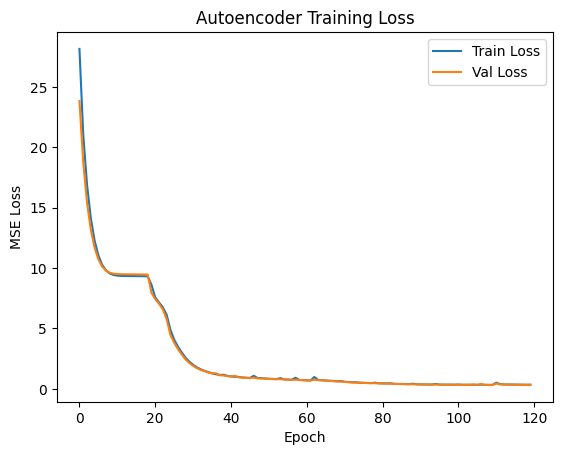

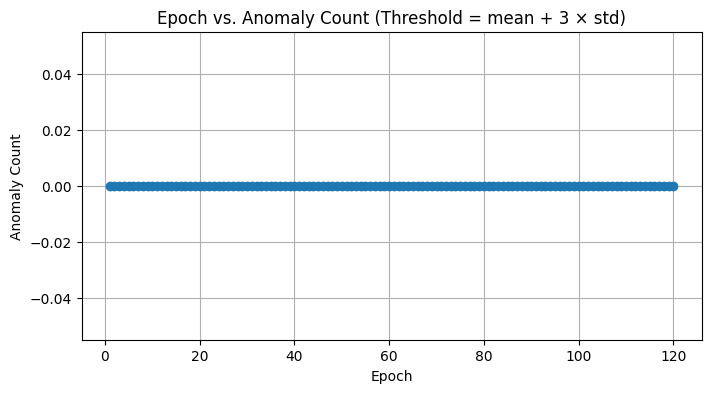

347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
전체 데이터의 평균 재구성 오차: 0.32802466
최종 임계치: 0.41012523
이상 데이터 갯수: 0


In [28]:
# 7. 모델 학습 (정상 데이터만 사용)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
anomaly_callback = AnomalyCountCallback(X)

history = autoencoder.fit(X, X, 
                          epochs=150,
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[es, anomaly_callback],
                          verbose=1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

# 학습 완료 후 에포크별 임계치를 넘은 데이터 갯수 시각화
plt.figure(figsize=(8,4))
plt.plot(range(1, len(anomaly_callback.epoch_anomaly_counts) + 1), 
         anomaly_callback.epoch_anomaly_counts, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Anomaly Count')
plt.title('Epoch vs. Anomaly Count (Threshold = mean + 3 × std)')
plt.grid(True)
plt.show()

# 최종 모델로 전체 데이터에 대한 재구성 오차 및 최종 임계치 계산
X_pred = autoencoder.predict(X)
reconstruction_errors = np.mean(np.square(X_pred - X), axis=(1,2))
final_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
final_anomaly_count = np.sum(reconstruction_errors > final_threshold)
print("전체 데이터의 평균 재구성 오차:", np.mean(reconstruction_errors))
print("최종 임계치:", final_threshold)
print("이상 데이터 갯수:", final_anomaly_count)

In [29]:
# # 9. 학습 후 최종 모델 평가 시, 전체 데이터에 대한 재구성 오차와 임계치를 계산
# X_pred = autoencoder.predict(X)
# reconstruction_errors = np.mean(np.square(X_pred - X), axis=(1,2))
# final_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
# print("최종 임계치:", final_threshold)

# # 모델 저장
# autoencoder.save('autoencoder_model.h5')

# # 임계치 저장
# with open('threshold.pkl', 'wb') as f:
#     pickle.dump(final_threshold, f)

# # LabelEncoder 저장
# with open('event_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_event, f)

# with open('hub_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_hub, f)
    
# # MinMaxScaler 저장
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)